# Visualiazation Experiments

This notebook is a an exploratory work on what visualizations for Gutenberg project statistics data ([sample](https://github.com/leomrocha/mix_nlp/tree/master/gutenberg_stats_examples)) could be interesting too look at. It also contains some experiments on what library to use when building visualizations from existing data and how.

In [1]:
EXAMPLE_DIR = '../../gutenberg_stats_examples/'

In [2]:
# data is stored as json, lots of nesting

import gzip
import json    

with gzip.open(f'{EXAMPLE_DIR}/2568-0.stats_all.json.gz', "rb") as f:
    trents_last_case = json.loads(f.read())
    
trents_last_case.keys()

dict_keys(['metadata', 'file_stats', 'stats_data', 'tokens'])

In [3]:
# save as different files to explore separately

for stat in trents_last_case.keys():
    with open(f"../../gutenberg_stats_examples/2568-0/{stat}.json", "w") as f:
        json.dump(trents_last_case[stat], f, indent=2)

In [4]:
import pandas as pd

words_by_sentence = pd.Series(trents_last_case['stats_data']['by_sentence']['word_length'])
words_by_paragraph = pd.Series(trents_last_case['stats_data']['by_paragraph']['word_length'])

In [5]:
words_by_sentence.index

Index(['2', '1', '0', '6', '31', '10', '9', '3', '44', '18', '15', '24', '21',
       '11', '12', '5', '7', '4', '17', '23', '8', '13', '14', '16', '26',
       '25', '35', '19', '29', '33', '20', '22', '27', '30', '28', '34', '43',
       '75', '40', '37', '32'],
      dtype='object')

In [6]:
sentence_wc = words_by_sentence
sentence_wc.index = sentence_wc.index.astype('int64')
sentence_wc.sort_index(inplace=True)
sentence_wc = sentence_wc[1:]
sentence_wc

1     470
2     607
3     564
4     542
5     459
6     406
7     336
8     269
9     229
10    185
11    156
12    106
13     90
14     73
15     59
16     44
17     33
18     32
19     18
20     19
21      3
22     13
23     10
24      6
25      8
26      7
27      1
28      3
29      2
30      2
31      2
32      1
33      2
34      1
35      1
37      1
40      1
43      1
44      1
75      1
dtype: int64

In [7]:
x = sentence_wc.index.values
y = sentence_wc.values

## Finding the library

### Seaborn

This library is Python-only, does not have any interactivity, suits for publishing notebooks directly (without a webapp at all). It's easy to use with raw data (when no statistics are calculated yet), but because the data we have is already computed statistics, not so useful.

Onhover behavior can be added with additional library [mplcursors](https://stackoverflow.com/a/61337574/9076659)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

In [9]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

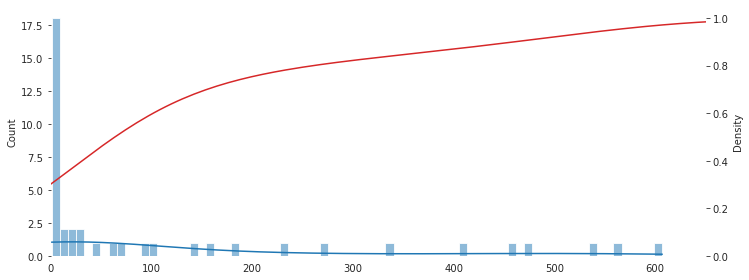

In [10]:
# (failed attempt) tried to use seaborn in an easy way
# the difficulty is seaborn expects raw data from
# which it itself calculates the frequency, but we already have a frequency
# the plot is not correct

# histogram and KDE
sns.displot(words_by_sentence, bins=75, kde=True, height=4, aspect=2.5)
ax = plt.twinx() # add second y axis 
ax.set_xlim(0, 650)

# CDF 
sns.kdeplot(
    data=words_by_sentence, cumulative=True, 
    ax=ax, color=sns.color_palette()[3]
)
sns.despine(left=True, bottom=True)
plt.show()

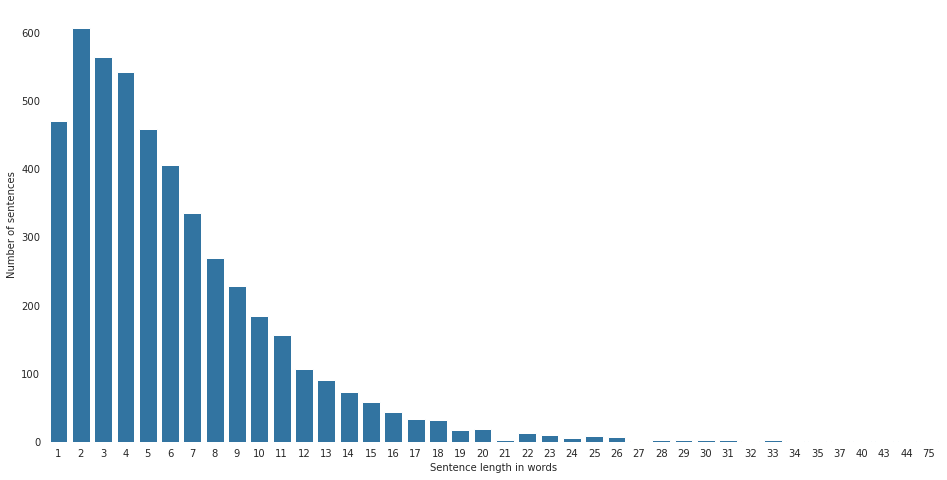

In [11]:
# to be able to graph from existing frequency need to use bar chart
plt.figure(figsize=(16,8))
ax = sns.barplot(x=x, y=y, color=sns.color_palette()[0])
sns.despine(left=True, bottom=True)
plt.xlabel('Sentence length in words')
plt.ylabel('Number of sentences')
plt.show()

### Chartify

https://github.com/spotify/chartify

Basically suffers from the same as seaborn - tries to compute everything itself, including frequency tables. [docs](https://chartify.readthedocs.io/en/latest/usage.html#chartify._core.plot.PlotNumericDensityXY). A downside is that the API for that library is very much unlike the one for matplotlib / seaborn, maybe because it's based on bokeh.

From the upside - may be extended with bokeh when needed.

In [12]:
# a very simple usage does not work

# import chartify

# ch = chartify.Chart(x_axis_type='categorical')

# ch.set_title("Title")
# ch.set_subtitle("Subtitle")
# ch.plot.bar(
#     data_frame=pd.DataFrame(sentence_wc),
# #     categorical_columns='fruit',
# #     numeric_column='quantity',
# #     categorical_order_by='labels',
# #     categorical_order_ascending=True
# )

### Bokeh

## TODO

find out if jupyter **interactions** can be easily exported to JS

Bokeh as an ability to have dropdown menus, etc. [docs](https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html#jupyter-interactors). Probably we can just create **everything** in a notebook and then extract.

With a JS library https://github.com/jsvine/notebookjs => workding demo https://jsvine.github.io/nbpreview/

Or with standart jupyter API https://ipywidgets.readthedocs.io/en/stable/embedding.html

In [166]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import LinearAxis, Range1d, DataRange1d
from bokeh.models import ColumnDataSource, Label

from bokeh.models import PanTool, BoxZoomTool, ResetTool, SaveTool, HoverTool, CrosshairTool

from bokeh.palettes import Bokeh, Category20c, Colorblind

import scipy.stats

In [14]:
bokeh_colors = Bokeh[7]

In [15]:
output_notebook()

Loading BokehJS ...

In [16]:
def create_data_source(frequency_table):
    
    # since we already have the frequencies 
    # we should not compute them again
    # only computing edges
    hist = frequency_table.reindex(range(1, max(frequency_table.index) + 1), fill_value=0)
    _, edges = np.histogram(frequency_table.index, bins=max(frequency_table.index))
    x = hist.index
    
    # these numbers are not correct
    # they are present only as approximation to explore visualizations
    # source https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_histogram.html
    hist_dist = scipy.stats.rv_histogram((hist, edges))
    pdf = hist_dist.pdf(x)
    cdf = hist_dist.cdf(x)
    
    return ColumnDataSource({
        'hist': hist,
        'bin_edges_left': edges[:-1],
        'bin_edges_right': edges[1:],
        'x': x,
        'pdf': pdf,
        'cdf': cdf
    })

# crash test
create_data_source(words_by_sentence)

ColumnDataSource(id='1002', ...)

In [222]:
# TODO: fix the hover tooltip it shows when x=0 that number of sentences=470
# happens because {int} bokeh tooltip formatter rounds down when < .5
def hist_pdf_cdf(frequency_table, title):
    """
    :param frequency_table: a pandas Series with integer index and integer values
    :returns: mock Bokeh plot
    """
    
    # colors
    cat = Colorblind[8]
    hist_color = cat[4]
    cdf_color = cat[1]
    pdf_color = cat[6]
    gray = '#9A9A9A'
    hist_text_color = "#1A87C7"
    
    data_source = create_data_source(frequency_table)
    
    # tools
    TOOLTIPS = """
    <div>
        <div>
            <span style="font-size: 18px; font-weight: bold; color:""" + hist_text_color + """;">@hist</span>
            <span style="font-size: 14px; color: """ + gray + """;">[$x{int}]</span>
        </div>
        <div>
            <span style="font-size: 12px; color: """ + pdf_color + """;">PDF = @pdf{1.111}</span>
        </div>
        <div>
            <span style="font-size: 12px; color: """ + cdf_color + """;">CDF = @cdf{1.111}</span>
        </div>
    </div>
"""
    hover_tool = HoverTool(
        mode='vline', 
        names=['hist'],
#         tooltips=[
#             ("number of words in a sentence", '$x{int}'),
#             ("number of sentences", "@hist{int}"),
#             ("pdf", "@pdf{1.111}"),
#             ("cdf", "@cdf{1.111}"),
#         ],
        anchor='center_right',
        point_policy='none',
        
        tooltips=TOOLTIPS
    )
    tools = [PanTool(), BoxZoomTool(), 
             hover_tool, CrosshairTool(line_alpha=0.8, line_width=.25), 
             SaveTool(), ResetTool()]
    
    # figure
    p = figure(title=title, 
               toolbar_location="above", tools=tools, toolbar_sticky=False,
               width=800, height=400)
    p.toolbar.logo = None
    
    
    # additional y axes
    pdf_max = max(data_source.data['pdf'])
    p.extra_y_ranges = {
        # range_padding doesn't work for additional y axes for some reason
#         "PDF": DataRange1d(start=0, end=pdf_max, range_padding = 5, range_padding_units = 'percent'),
        "PDF": DataRange1d(start=0, end=pdf_max*1.05, bounds ='auto'),
        "CDF": DataRange1d(start=0, end=1.05, bounds ='auto'),
    }
    p.add_layout(LinearAxis(y_range_name="PDF"), 'right')
    p.add_layout(LinearAxis(y_range_name="CDF"), 'right')

    # histogram
    p.quad(top='hist', bottom=0, name='hist', left='bin_edges_left', right='bin_edges_right',
       fill_color=hist_color, line_color="white", alpha=0.5, source=data_source)
    # PDF
    p.line('x', 'pdf', 
           line_color=pdf_color, line_width=3, 
           y_range_name="PDF", 
           source=data_source)
    # CDF
    p.line('x', 'cdf', 
           line_color=cdf_color, line_width=2, 
           y_range_name="CDF", 
           source=data_source)
    
    # Layout
    # common
    p.grid.grid_line_color=None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.axis.axis_line_width = 0
    p.axis.major_tick_out = 8
    p.axis.major_tick_in = 0
    #     p.axis.major_tick_line_width = 3
    
    # x axis
    p.xaxis.axis_label = 'Number of words'
    p.xaxis.major_tick_line_color = gray
    p.xaxis.axis_label_text_font_style = "normal"
    p.x_range.range_padding = 0.02
    
    # y axes
    p.y_range.start = 0
    p.y_range.bounds = 'auto'
    p.y_range.range_padding = 0.2
    hist_axis = p.yaxis[0]
    pdf_axis = p.yaxis[1]
    cdf_axis = p.yaxis[2]
    
    # hist axis
    print(hist_color)
    hist_axis.axis_label = "Number of sentences"
    hist_axis.axis_label_text_font_style = "normal"
    hist_axis.axis_label_standoff = 20
    hist_axis.axis_label_text_color = hist_text_color
    hist_axis.major_label_text_color = hist_text_color
    hist_axis.major_tick_line_color = hist_text_color
    hist_axis.ticker.desired_num_ticks = 4
    
    # cdf axis
    cdf_axis.major_label_text_color = cdf_color
    cdf_axis.ticker = np.linspace(0, 1, 5).tolist()
    cdf_axis.major_tick_in = 45
    cdf_axis.major_tick_line_color = cdf_color
    cdf_axis.major_tick_line_dash = [2, 3]
    # using hist on y position, because it's default y axis for labels
    p.add_layout(
        Label(text="CDF", text_color=cdf_color, 
              x_units='screen',
              y_units='screen',
              x=600,
              y=257,
#               x=0.9*max(data_source.data['x']), 
#               y=0.96*max(data_source.data['hist'])
             )
    )
    
    # pdf axis
    pdf_axis.major_label_text_color = pdf_color
    pdf_axis.ticker = np.linspace(pdf_max*0.1, pdf_max*0.9, 4).tolist()
    pdf_axis.major_tick_line_color = pdf_color
    p.add_layout(
        Label(text="PDF", text_color=pdf_color, 
              x_units='screen',
              y_units='screen',
              x=600,
              y=5
#               x=0.9*max(data_source.data['x']), 
#               y=0.01*max(data_source.data['hist'])
             )
    )


    #     print(p.axis[0].properties_with_values())
    return p
    
    
p1 = hist_pdf_cdf(words_by_sentence, "Number of sentences by number of words in the sentence")
show(p1)

#56B4E9
